In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set()
sns.set_style("white")
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)  
sns.set_palette("pastel")
pal = sns.color_palette("pastel")
colors = pal.as_hex()
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [2]:
from scipy.io import loadmat
digits = loadmat('digits')
# take out relevant parts
trainLabels = digits['trainLabels']
testLabels = digits['testLabels']
testImages = digits['testImages']
trainImages = digits['trainImages']

# reshape data to be vectors
trainImages = .99*trainImages.reshape(-1,60000)/255. + .01
testImages = .99*testImages.reshape(-1,10000)/255. + .01
# reshape expected results as well
trainLabels = trainLabels.reshape(60000)
testLabels = testLabels.reshape(10000)
# get onehot vectors
trainOneHot = np.zeros((len(trainLabels), 10))
trainOneHot[np.arange(trainLabels.size),trainLabels] = 1
testOneHot = np.zeros((len(testLabels), 10))
testOneHot[np.arange(testLabels.size),testLabels] = 1

trainOneHot = trainOneHot.T.astype(int)
testOneHot = testOneHot.T.astype(int)
# trainOneHot = np.squeeze(np.eye(10)[trainLabels.reshape(-1)]).reshape(10,-1)
# testOneHot = np.squeeze(np.eye(10)[testLabels.reshape(-1)]).reshape(10,-1)

trainLabels = trainLabels.reshape(60000,1)
testLabels = testLabels.reshape(10000,1)

print(trainImages.shape)
print(trainOneHot.shape)

(784, 60000)
(10, 60000)


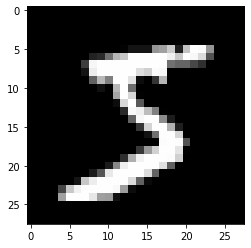

In [3]:
# plt.imshow(digits['trainImages'][:,:,:,1].reshape(28,28))
plt.imshow(trainImages[:,0].reshape(28,28), cmap="Greys_r") 

In [188]:
def softmax(x):
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    f = np.exp(shifted_x)
    p = f / np.sum(f, axis=1, keepdims=True)
    return p
        
class Sigmoid:
    def __call__(self, x):
        return 1/(1+np.exp(-x))
    def backward(self, x):
        return x*(1-x)

class LinearActivation:
    def __call__(self,x):
        return x
    def backward(self,x):
        return 1.0

class ReLU:
    def __call__(self,x):
        return np.clip(x, 0.0, None)
    def backward(self,x):
        grad = np.zeros_like(x) # zeros array of same shape as x
        grad[np.where(grad>0)] = 1.0
        return grad
    
class tanh:
    def __call__(self,x):
        return np.tanh(x)
    def backward(self,x):
        return 1-x**2

In [9]:
class SoftmaxCrossEntropy:
    def __call__(self, y, y_hat):
        probs = softmax(y_hat)
        loss = -np.sum(y * np.log(probs)/y.shape[1])
        return loss
    def backward(self, y, y_hat):
        probs = softmax(y_hat)
        return (probs - y)
    
class CrossEntropyLoss:
    def __call__(self, y, y_hat):
        loss_sum = np.sum(np.multiply(y, np.log(y_hat)))
        return -(1/y.shape[1]) * loss_sum
    def backward(self, y, y_hat):
        return y_hat - y

In [15]:
class NN:
    def __init__(self, layers, loss=SoftmaxCrossEntropy()):
        # set our list of layers and our loss function
        self.layers = layers
        self.loss_fn = loss

    def forward(self, x):
        # simply go straight through the network
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, labels):
        # iterate through each layer in reverse and calculate gradients
        dA = self.loss_fn.backward(labels, self.layers[-1].a)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)

    def predict(self, data):
        # predict the class by getting the max index
        pred = self.forward(data)
        probs = softmax(pred)
        return np.argmax(probs, axis=1)

    def update(self, lr=.1):
        # update after gradients are calculated using gradient descent method
        for layer in self.layers:
            layer.weights -= lr * layer.dW
            layer.biases -= lr * layer.db
            
class Linear:
    def __init__(self, input_dim, output_dim, activation=Sigmoid()):
        # dividing by sqrt of input dim makes it better
        self.weights = np.random.randn(input_dim, output_dim)/np.sqrt(input_dim)
        self.biases = np.zeros((1, output_dim))
        self.activation = activation

    def forward(self, x):
        # very straight forward. save some values for the backwards step
        pred = np.dot(x, self.weights) + self.biases
        self.a = self.activation(pred)
        self.x = x
        return self.a

    def backward(self, next_dA):
        # next dA is passed in, meaning the gradient of the output of the next layer
        # update the weights with respect to the gradients calculated in the next layer
        dz = next_dA * self.activation.backward(self.a)
        self.db = np.sum(dz, axis=0)
        self.dW = np.dot(self.x.T, dz)
        # now calculate the gradients of this layer 
        dA = np.dot(dz, self.weights.T)
        # divide gradients by batch size to make work
        self.db /= dz.shape[0]
        self.dW /= dz.shape[0]
        # we return out layer's gradient so that the previous layer can get it
        return dA






# First Test

In [ ]:
layers = [Linear(784, 128, activation=Sigmoid()), 
          Linear(128,10,   activation=LinearActivation())]

model = NN(layers)
trainX = trainImages.T
trainY = trainOneHot.T
testX = testImages.T
testY = testOneHot.T

epochs = 50
batch_size = 250
train_acc = []
test_acc = []


for i in range(epochs):
    # TRAIN
    sum_loss = 0.0
    for j in range((train_data.shape[0] - 1) // batch_size + 1):
        batch_data = trainX[j*batch_size:(j+1)*batch_size]
        batch_labels = trainY[j*batch_size:(j+1)*batch_size]
        pred = model.forward(batch_data)
        loss = model.loss_fn(batch_labels, pred)
        sum_loss += loss
        model.backward(batch_labels)
        model.update(.01)
    train_loss = sum_loss/(j+1)
    
    # CHECK TEST ACCURACY
    test_pred = model.predict(testX)
#     test_loss = model.loss_fn(testY, test_pred)    
    test_accuracy = np.sum(test_pred == np.argmax(test_labels, axis=1)) / np.float(test_labels.shape[0])
    
    train_accuracy = np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / np.float(train_labels.shape[0])
    
    test_acc.append(test_accuracy)
    train_acc.append(train_accuracy)
    
    
    print("epoch {}. test accuracy {}".format(i, test_accuracy))


Text(0.5, 1.0, 'Test/Train Accuracies Over Iterations (lr=.01)')

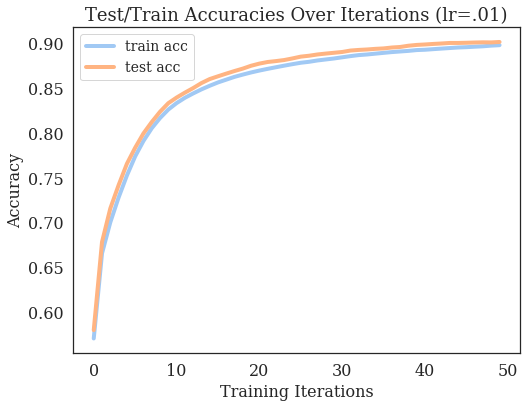

In [109]:
fig = plt.figure(figsize=(8, 6))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
plt.plot(train_acc, label='train acc', linewidth=4)
plt.plot(test_acc, label='test acc', linewidth=4)
plt.legend(prop={'size': 14})

plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Test/Train Accuracies Over Iterations (lr=.01)', fontsize=18)

# Differences in Learning Rate

In [100]:
train_accs = []
test_accs = []

for cur_idx, lr in enumerate([1, .5, .1, .01, .001]):    
    layers = [Linear(784, 128, activation=Sigmoid()), 
              Linear(128,10,   activation=LinearActivation())]
    model = NN(layers)

    trainX = trainImages.T
    trainY = trainOneHot.T
    testX = testImages.T
    testY = testOneHot.T

    epochs = 50
    batch_size = 250
    train_accs.append([])
    test_accs.append([])


    for i in range(epochs):
        # TRAIN
        sum_loss = 0.0
        for j in range((train_data.shape[0] - 1) // batch_size + 1):
            batch_data = trainX[j*batch_size:(j+1)*batch_size]
            batch_labels = trainY[j*batch_size:(j+1)*batch_size]
            pred = model.forward(batch_data)
            loss = model.loss_fn(batch_labels, pred)
            sum_loss += loss
            model.backward(batch_labels)
            model.update(.01)
        train_loss = sum_loss/(j+1)
        
        
        # TRAIN
        sum_loss = 0.0
        for j in range((n_train - 1) // batch_size + 1):
            batch_data = train_data[j*batch_size:(j+1)*batch_size]
            batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
            pred = model.forward(batch_data)
            loss = model.loss_fn(batch_labels, pred)
            sum_loss += loss
            model.backward(batch_labels)
            model.update(lr)
        train_loss = sum_loss/(j+1)

        # CHECK TEST ACCURACY
        test_pred = model.predict(test_data)
        test_accuracy = np.sum(test_pred == np.argmax(test_labels, axis=1)) / np.float(test_labels.shape[0])

        train_accuracy = np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / np.float(train_labels.shape[0])
        test_accs[cur_idx].append(test_accuracy)
        train_accs[cur_idx].append(train_accuracy)


        print("epoch {}. test accuracy {}".format(i, test_accuracy))


====================Epoch 0====================
Train loss 14.54304601211431 accuracy 0.9007666666666667


test accuracy 0.907
====================Epoch 1====================
Train loss 7.197926646852319 accuracy 0.9242833333333333


test accuracy 0.9261
====================Epoch 2====================
Train loss 5.949852686715222 accuracy 0.9371333333333334


test accuracy 0.9375
====================Epoch 3====================
Train loss 5.08667800343685 accuracy 0.9466666666666667


test accuracy 0.9454
====================Epoch 4====================
Train loss 4.447332741269105 accuracy 0.9528333333333333


test accuracy 0.9512
====================Epoch 5====================
Train loss 3.949141226557019 accuracy 0.95815


test accuracy 0.9552
====================Epoch 6====================
Train loss 3.548746555485065 accuracy 0.9626


test accuracy 0.9592
====================Epoch 7====================
Train loss 3.2199755517055033 accuracy 0.9657666666666667


test accuracy 0.9619


Text(0.5, 1.0, 'Test Accuracies Over Iterations (Various Learning Rates)')

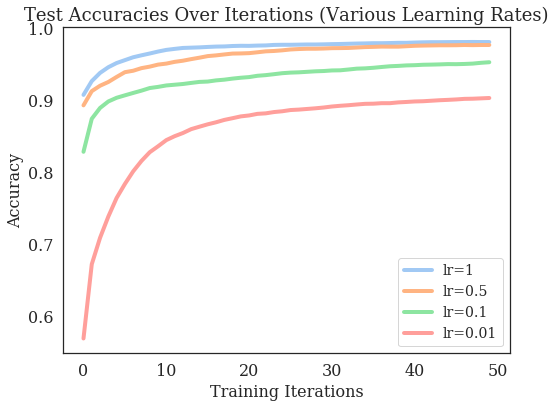

In [104]:
accs = np.array(test_accs)
fig = plt.figure(figsize=(8, 6))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
# plt.plot(train_accs, label='train acc', linewidth=4)
for cur_idx, lr in enumerate([1, .5, .1, .01]):    
    plt.plot(accs[cur_idx], label='lr={}'.format(lr), linewidth=4)

plt.legend(prop={'size': 14})

plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Test Accuracies Over Iterations (Various Learning Rates)', fontsize=18)

# Decaying Learning Rate

In [123]:
layers = [Linear(784, 128, activation=Sigmoid()), 
          Linear(128,10,   activation=LinearActivation())]

model = NN(layers)
trainX = trainImages.T
trainY = trainOneHot.T
testX = testImages.T
testY = testOneHot.T

epochs = 50
batch_size = 250
train_acc = []
test_acc = []

lr = 1.0
count = 0
for i in range(epochs):
    # TRAIN
    sum_loss = 0.0
    for j in range((train_data.shape[0] - 1) // batch_size + 1):
        batch_data = trainX[j*batch_size:(j+1)*batch_size]
        batch_labels = trainY[j*batch_size:(j+1)*batch_size]
        pred = model.forward(batch_data)
        loss = model.loss_fn(batch_labels, pred)
        sum_loss += loss
        model.backward(batch_labels)
        model.update(lr)
    count += 1
    if count % 1000 == 0:
        lr *= (1. / (1. + .99 * count))

    train_loss = sum_loss/(j+1)
    
    # CHECK TEST ACCURACY
    test_pred = model.predict(testX)
#     test_loss = model.loss_fn(testY, test_pred)    
    test_accuracy = np.sum(test_pred == np.argmax(test_labels, axis=1)) / np.float(test_labels.shape[0])
    
    train_accuracy = np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / np.float(train_labels.shape[0])
    
    test_acc.append(test_accuracy)
    train_acc.append(train_accuracy)
    
    
    print("epoch {}. test accuracy {}".format(i, test_accuracy))


epoch 0. test accuracy 0.9066
epoch 1. test accuracy 0.9239
epoch 2. test accuracy 0.9369
epoch 3. test accuracy 0.945
epoch 4. test accuracy 0.9496
epoch 5. test accuracy 0.9544
epoch 6. test accuracy 0.9581
epoch 7. test accuracy 0.9598
epoch 8. test accuracy 0.963
epoch 9. test accuracy 0.9655
epoch 10. test accuracy 0.9678
epoch 11. test accuracy 0.9686
epoch 12. test accuracy 0.9701
epoch 13. test accuracy 0.9713
epoch 14. test accuracy 0.9723
epoch 15. test accuracy 0.9729
epoch 16. test accuracy 0.9738
epoch 17. test accuracy 0.9747
epoch 18. test accuracy 0.9755
epoch 19. test accuracy 0.9766
epoch 20. test accuracy 0.9769
epoch 21. test accuracy 0.9772
epoch 22. test accuracy 0.9773
epoch 23. test accuracy 0.9773
epoch 24. test accuracy 0.9778
epoch 25. test accuracy 0.9781
epoch 26. test accuracy 0.9784
epoch 27. test accuracy 0.9787
epoch 28. test accuracy 0.9787
epoch 29. test accuracy 0.9794
epoch 30. test accuracy 0.9792
epoch 31. test accuracy 0.9797
epoch 32. test accur

Text(0.5, 1.0, 'Test Accuracies Over Iterations (Various Learning Rates)')

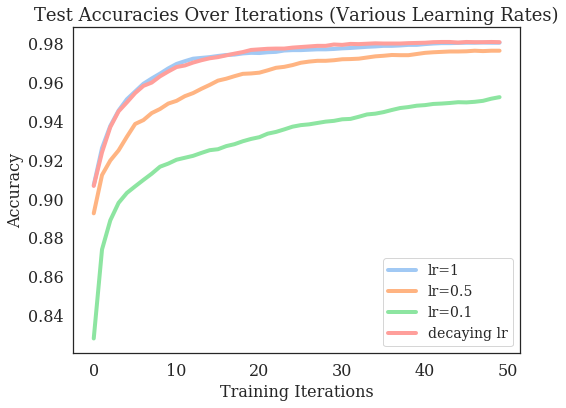

In [126]:
accs = np.array(test_accs)
fig = plt.figure(figsize=(8, 6))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
# plt.plot(train_accs, label='train acc', linewidth=4)
for cur_idx, lr in enumerate([1, .5, .1]):    
    plt.plot(accs[cur_idx], label='lr={}'.format(lr), linewidth=4)
plt.plot(test_acc, label='decaying lr', linewidth=4)
plt.legend(prop={'size': 14})

plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('Test Accuracies Over Iterations (Various Learning Rates)', fontsize=18)

In [237]:
train_accs = []
test_accs = []

for cur_idx, hidden in enumerate(np.arange(8, 784+1, 8)):    
    print('*'*20, 'hidden units {}'.format(hidden), '*'*20)
    layers = [Linear(784, hidden, activation=Sigmoid()), 
              Linear(hidden,10,   activation=LinearActivation())]
    model = NN(layers)
    lr = 1
    trainX = trainImages.T
    trainY = trainOneHot.T
    testX = testImages.T
    testY = testOneHot.T

    epochs = 30
    batch_size = 250
    train_accs.append([])
    test_accs.append([])
    count = 0

    for i in range(epochs):
        # TRAIN
        sum_loss = 0.0
        for j in range((train_data.shape[0] - 1) // batch_size + 1):
            batch_data = trainX[j*batch_size:(j+1)*batch_size]
            batch_labels = trainY[j*batch_size:(j+1)*batch_size]
            pred = model.forward(batch_data)
            loss = model.loss_fn(batch_labels, pred)
            sum_loss += loss
            model.backward(batch_labels)
            model.update(lr)
        count += 1
        if count % 1000 == 0:
            lr *= (1. / (1. + .99 * count))
            
        train_loss = sum_loss/(j+1)
        
        
        # TRAIN
        sum_loss = 0.0
        for j in range((n_train - 1) // batch_size + 1):
            batch_data = train_data[j*batch_size:(j+1)*batch_size]
            batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
            pred = model.forward(batch_data)
            loss = model.loss_fn(batch_labels, pred)
            sum_loss += loss
            model.backward(batch_labels)
            model.update(lr)
        train_loss = sum_loss/(j+1)

        # CHECK TEST ACCURACY
        test_pred = model.predict(test_data)
        test_accuracy = np.sum(test_pred == np.argmax(test_labels, axis=1)) / np.float(test_labels.shape[0])

        train_accuracy = np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / np.float(train_labels.shape[0])
        test_accs[cur_idx].append(test_accuracy)
        train_accs[cur_idx].append(train_accuracy)


        print("epoch {}. test accuracy {}".format(i, test_accuracy))


******************** hidden units 8 ********************
epoch 0. test accuracy 0.8978
epoch 1. test accuracy 0.9093
epoch 2. test accuracy 0.9113
epoch 3. test accuracy 0.9146
epoch 4. test accuracy 0.9169
epoch 5. test accuracy 0.9184
epoch 6. test accuracy 0.9199
epoch 7. test accuracy 0.9198
epoch 8. test accuracy 0.9196
epoch 9. test accuracy 0.9213
epoch 10. test accuracy 0.9218
epoch 11. test accuracy 0.9211
epoch 12. test accuracy 0.9215
epoch 13. test accuracy 0.9231
epoch 14. test accuracy 0.9242
epoch 15. test accuracy 0.9247
epoch 16. test accuracy 0.9251
epoch 17. test accuracy 0.9251
epoch 18. test accuracy 0.9251
epoch 19. test accuracy 0.9255
epoch 20. test accuracy 0.9257
epoch 21. test accuracy 0.9262
epoch 22. test accuracy 0.9263
epoch 23. test accuracy 0.9262
epoch 24. test accuracy 0.9273
epoch 25. test accuracy 0.9272
epoch 26. test accuracy 0.9273
epoch 27. test accuracy 0.9267
epoch 28. test accuracy 0.9263
epoch 29. test accuracy 0.9264
******************** hi

[0.9264 0.9486 0.9607 0.9675 0.9713 0.9737 0.9763 0.976  0.9787 0.9786
 0.9788 0.9777 0.979  0.9803 0.9805 0.9791 0.9799 0.9813 0.9811 0.9803
 0.9813 0.9816 0.981  0.9806 0.9807 0.9801 0.9802 0.9812 0.9813 0.98
 0.9814 0.9807 0.9814 0.9811 0.9798 0.9804 0.9807 0.9793 0.9801 0.9806
 0.9805 0.981  0.9806 0.9815 0.9803 0.9815 0.9812 0.9817 0.9804 0.9802
 0.98   0.9793 0.9815 0.9819 0.9811 0.981  0.9811 0.9809 0.9795 0.981
 0.9799 0.9806 0.98   0.98   0.9804 0.9797 0.9811 0.9772 0.9771 0.9805
 0.9797 0.9803 0.9806 0.9802 0.9803 0.9814 0.9802 0.9805 0.9795 0.9792
 0.979  0.9771 0.9798 0.9793 0.9778 0.9795 0.9792 0.9808 0.9799 0.9801
 0.9777 0.9797 0.9781 0.9788 0.9803 0.9786 0.9806 0.9797]


Text(0.5, 1.0, 'Test Accuracy for Various Hidden Unit Sizes')

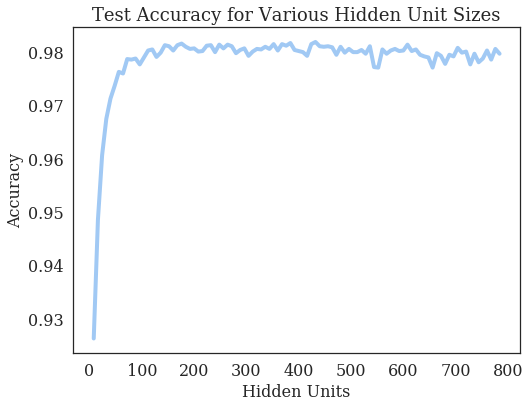

In [239]:
accs = np.array(test_accs)
fig = plt.figure(figsize=(8, 6))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
# plt.plot(train_accs, label='train acc', linewidth=4)
# for cur_idx, hidden in enumerate(np.arange(1, 256, 16)):  
#     if cur_idx == 0:
#         continue
#     plt.plot(accs[cur_idx], label='hidden units={}'.format(hidden), linewidth=4)
# plt.legend(prop={'size': 14})
plt.plot(np.arange(8, 784+1, 8),accs[:,-1], linewidth=4)
print(accs[:,-1])
# plt.xticks(np.arange(16, 256, 16))
plt.xlabel('Hidden Units')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Various Hidden Unit Sizes', fontsize=18)

# Different Architectures/Activations

In [196]:
train_accs = []
test_accs = []

layers_list = [[Linear(784, 100, activation=ReLU()), Linear(100,10,   activation=LinearActivation())],
               [Linear(784, 100, activation=tanh()), Linear(100,10,   activation=LinearActivation())],
               [Linear(784, 100, activation=Sigmoid()), Linear(100,10,   activation=LinearActivation())],

              [Linear(784, 500, activation=Sigmoid()), Linear(500, 300, activation=Sigmoid()), Linear(300,10,   activation=LinearActivation())]
              ]

lr = 1
for cur_idx, layers in enumerate(layers_list):    
    print('*'*20, 'hidden units {}'.format(hidden), '*'*20)
#     layers = [Linear(784, hidden, activation=Sigmoid()), 
#               Linear(hidden,10,   activation=LinearActivation())]
    model = NN(layers)

    trainX = trainImages.T
    trainY = trainOneHot.T
    testX = testImages.T
    testY = testOneHot.T

    epochs = 20
    batch_size = 250
    train_accs.append([])
    test_accs.append([])
    count = 0

    for i in range(epochs):
        # TRAIN
        sum_loss = 0.0
        for j in range((train_data.shape[0] - 1) // batch_size + 1):
            batch_data = trainX[j*batch_size:(j+1)*batch_size]
            batch_labels = trainY[j*batch_size:(j+1)*batch_size]
            pred = model.forward(batch_data)
            loss = model.loss_fn(batch_labels, pred)
            sum_loss += loss
            model.backward(batch_labels)
            model.update(lr)
        count += 1
        if count % 1000 == 0:
            lr *= (1. / (1. + .99 * count))
            
        train_loss = sum_loss/(j+1)
        
        
        # TRAIN
        sum_loss = 0.0
        for j in range((n_train - 1) // batch_size + 1):
            batch_data = train_data[j*batch_size:(j+1)*batch_size]
            batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
            pred = model.forward(batch_data)
            loss = model.loss_fn(batch_labels, pred)
            sum_loss += loss
            model.backward(batch_labels)
            model.update(lr)
        train_loss = sum_loss/(j+1)

        # CHECK TEST ACCURACY
        test_pred = model.predict(test_data)
        test_accuracy = np.sum(test_pred == np.argmax(test_labels, axis=1)) / np.float(test_labels.shape[0])

        train_accuracy = np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / np.float(train_labels.shape[0])
        test_accs[cur_idx].append(test_accuracy)
        train_accs[cur_idx].append(train_accuracy)


        print("epoch {}. test accuracy {}".format(i, test_accuracy))


******************** hidden units 784 ********************
epoch 0. test accuracy 0.81
epoch 1. test accuracy 0.8276
epoch 2. test accuracy 0.8371
epoch 3. test accuracy 0.8415
epoch 4. test accuracy 0.8449
epoch 5. test accuracy 0.8464
epoch 6. test accuracy 0.8479
epoch 7. test accuracy 0.8493
epoch 8. test accuracy 0.85
epoch 9. test accuracy 0.8515
epoch 10. test accuracy 0.8519
epoch 11. test accuracy 0.853
epoch 12. test accuracy 0.8537
epoch 13. test accuracy 0.8552
epoch 14. test accuracy 0.8559
epoch 15. test accuracy 0.8568
epoch 16. test accuracy 0.8572
epoch 17. test accuracy 0.8573
epoch 18. test accuracy 0.8574
epoch 19. test accuracy 0.8578
******************** hidden units 784 ********************
epoch 0. test accuracy 0.9547
epoch 1. test accuracy 0.9681
epoch 2. test accuracy 0.9712
epoch 3. test accuracy 0.9739
epoch 4. test accuracy 0.9759
epoch 5. test accuracy 0.9762
epoch 6. test accuracy 0.9768
epoch 7. test accuracy 0.9767
epoch 8. test accuracy 0.9769
epoch 9

(4, 20)


Text(0.5, 1.0, '2-Layer FNNs using Different Nonlinear Activations')

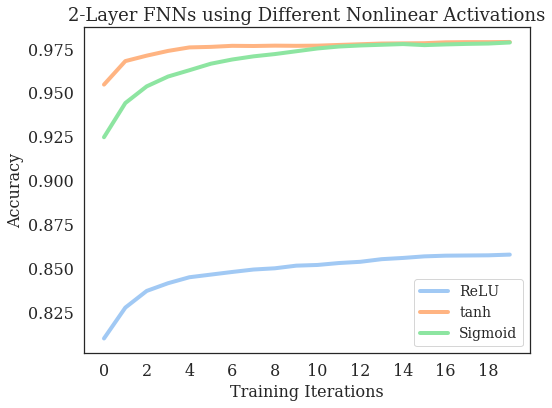

In [209]:
accs = np.array(test_accs)
print(accs.shape)
fig = plt.figure(figsize=(8, 6))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)
# plt.plot(train_accs, label='train acc', linewidth=4)
# for i in range(3):    
#     plt.plot(accs[i], label='net{}'.format(i), linewidth=4)
plt.plot(accs[0], label='ReLU'.format(i), linewidth=4)
plt.plot(accs[1], label='tanh'.format(i), linewidth=4)
plt.plot(accs[2], label='Sigmoid'.format(i), linewidth=4)
    
plt.legend(prop={'size': 14})
plt.xticks(np.arange(20,step=2))
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.title('2-Layer FNNs using Different Nonlinear Activations', fontsize=18)

# Confusion Matrix

In [211]:
layers = [Linear(784, 100, activation=tanh()), 
          Linear(100,10,   activation=LinearActivation())]

model = NN(layers)
trainX = trainImages.T
trainY = trainOneHot.T
testX = testImages.T
testY = testOneHot.T

epochs = 50
batch_size = 250
train_acc = []
test_acc = []

lr = 1.0
count = 0
for i in range(epochs):
    # TRAIN
    sum_loss = 0.0
    for j in range((train_data.shape[0] - 1) // batch_size + 1):
        batch_data = trainX[j*batch_size:(j+1)*batch_size]
        batch_labels = trainY[j*batch_size:(j+1)*batch_size]
        pred = model.forward(batch_data)
        loss = model.loss_fn(batch_labels, pred)
        sum_loss += loss
        model.backward(batch_labels)
        model.update(lr)
    count += 1
    if count % 1000 == 0:
        lr *= (1. / (1. + .99 * count))

    train_loss = sum_loss/(j+1)
    
    # CHECK TEST ACCURACY
    test_pred = model.predict(testX)
#     test_loss = model.loss_fn(testY, test_pred)    
    test_accuracy = np.sum(test_pred == np.argmax(test_labels, axis=1)) / np.float(test_labels.shape[0])
    
    train_accuracy = np.sum(model.predict(train_data) == np.argmax(train_labels, axis=1)) / np.float(train_labels.shape[0])
    
    test_acc.append(test_accuracy)
    train_acc.append(train_accuracy)
    
    
    print("epoch {}. test accuracy {}".format(i, test_accuracy))


epoch 0. test accuracy 0.9384
epoch 1. test accuracy 0.9577
epoch 2. test accuracy 0.9647
epoch 3. test accuracy 0.9669
epoch 4. test accuracy 0.9693
epoch 5. test accuracy 0.9717
epoch 6. test accuracy 0.9732
epoch 7. test accuracy 0.9731
epoch 8. test accuracy 0.9735
epoch 9. test accuracy 0.9743
epoch 10. test accuracy 0.9755
epoch 11. test accuracy 0.976
epoch 12. test accuracy 0.976
epoch 13. test accuracy 0.9764
epoch 14. test accuracy 0.9763
epoch 15. test accuracy 0.9764
epoch 16. test accuracy 0.9771
epoch 17. test accuracy 0.9771
epoch 18. test accuracy 0.9769
epoch 19. test accuracy 0.977
epoch 20. test accuracy 0.9768
epoch 21. test accuracy 0.9775
epoch 22. test accuracy 0.9774
epoch 23. test accuracy 0.9774
epoch 24. test accuracy 0.9775
epoch 25. test accuracy 0.9773
epoch 26. test accuracy 0.9776
epoch 27. test accuracy 0.9779
epoch 28. test accuracy 0.9782
epoch 29. test accuracy 0.9783
epoch 30. test accuracy 0.9785
epoch 31. test accuracy 0.9788
epoch 32. test accura

In [217]:
test_pred = model.predict(testX)
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(testLabels, test_pred)
print(confusion)

[[ 969    0    0    0    0    4    4    2    1    0]
 [   0 1130    1    1    0    1    1    1    0    0]
 [   5    2 1001    3    2    0    2    7   10    0]
 [   0    0    5  984    1    7    0    3    4    6]
 [   0    0    2    0  966    0    4    0    1    9]
 [   4    0    0    6    0  871    4    1    4    2]
 [   6    2    3    1    4    2  940    0    0    0]
 [   0    4    8    2    2    0    0 1000    3    9]
 [   4    3    4    3    1    5    0    4  945    5]
 [   0    3    0    5   11    4    0    3    4  979]]


Text(0.5, 1, 'Confusion Matrix for 2-Layer NN using tanh Activation')

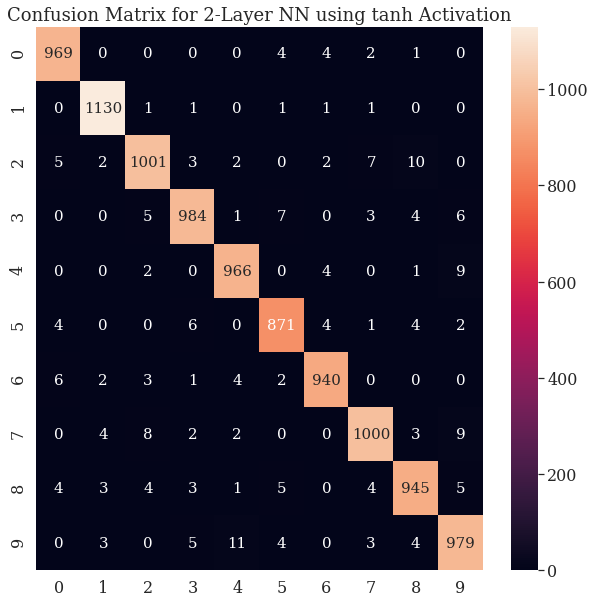

In [234]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion, annot=True, annot_kws={"size": 15},fmt="d")
plt.title('Confusion Matrix for 2-Layer NN using tanh Activation', fontsize=18)